## A Financial Research Agent in 6 easy steps

The overwhelming volume and complexity of financial data that limits timely, informed decision-making. 
Cognitive AI agents democratize access to insight by processing vast amounts of financial documents, earnings calls, filings, and macroeconomic data in real time. These are capabilities previously reserved for large AI -augmented analyst teams. Agents drastically reduce research cycle times by automating literature sourcing and reviews, hypothesis generation, and backtesting, enabling professionals and individuals alike to move faster. Unlike human analysts, AI agents are data-driven and free from cognitive biases like overconfidence or recency effects, offering more consistent decision support. They also help uncover alpha by analyzing niche datasets such as ESG reports or social media sentiment, and bridge global information gaps through multilingual capabilities. In essence, financial AI agents turn a deluge of unstructured information into actionable, accessible intelligence—making financial research more efficient, inclusive, and scalable

#### Step 1: Since this cookbook will be using OpenAI's Agent SDK. Ensure that the SDK is installed.

In [ ]:
#%pip install --upgrade openai-agents asyncio pydantic

**Step 1:** Since this cookbook will be using OpenAI's Agent SDK. Ensure that the SDK is installed and all relevant libraries installed

In [2]:
import asyncio
import os

In [3]:
from pydantic import BaseModel
from agents import Agent

In [4]:
from __future__ import annotations

import asyncio
import time
from collections.abc import Sequence

from rich.console import Console

from agents import Runner, RunResult, custom_span, gen_trace_id, trace
from agents import Agent, WebSearchTool
from agents.model_settings import ModelSettings


**Step 2:** Configure your OpenAI key. Of course the prerequisite is that you have an account.

In [1]:
openai_key="<YOUR KEY>"
os.environ["OPENAI_API_KEY"] = openai_key

**Step 3:** Define the different agents.

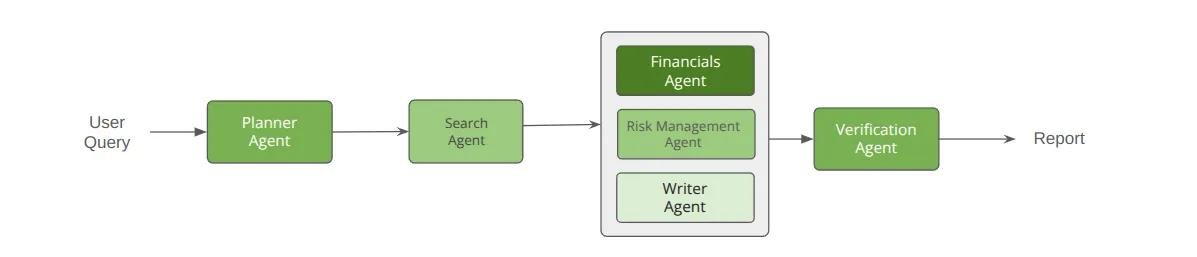

**Planner Agent**: Breaks down the user's query into a structured search plan to guide the research process.

**Search Agent**: Executes the plan by performing web searches and gathering relevant financial data.

**Financial & Risk Agents (as Tools)**: Analyze key financial metrics and assess potential red flags based on the search results.

**Writer Agent**: Synthesizes all findings into a coherent, structured financial report.

**Verifier Agent**: Reviews the final report for factual consistency and accuracy before presenting it to the user.

**Step 4:** Implement the agents.

##### Financials Agent

In [5]:
# A sub‑agent focused on analyzing a company's fundamentals.
FINANCIALS_PROMPT = (
    "You are a financial analyst focused on company fundamentals such as revenue, "
    "profit, margins and growth trajectory. Given a collection of web (and optional file) "
    "search results about a company, write a concise analysis of its recent financial "
    "performance. Pull out key metrics or quotes. Keep it under 2 paragraphs."
)


class AnalysisSummary(BaseModel):
    summary: str
    """Short text summary for this aspect of the analysis."""


financials_agent = Agent(
    name="FundamentalsAnalystAgent",
    instructions=FINANCIALS_PROMPT,
    output_type=AnalysisSummary,
)


##### Planner Agent

In [6]:
PROMPT = (
    "You are a financial research planner. Given a request for financial analysis, "
    "produce a set of web searches to gather the context needed. Aim for recent "
    "headlines, earnings calls or 10‑K snippets, analyst commentary, and industry background. "
    "Output between 5 and 15 search terms to query for."
)

class FinancialSearchItem(BaseModel):
    reason: str
    """Your reasoning for why this search is relevant."""

    query: str
    """The search term to feed into a web (or file) search."""

class FinancialSearchPlan(BaseModel):
    searches: list[FinancialSearchItem]
    """A list of searches to perform."""

planner_agent = Agent(
    name="FinancialPlannerAgent",
    instructions=PROMPT,
    model="o3-mini",
    output_type=FinancialSearchPlan,
)


##### Risk Management Agent

In [7]:
# A sub‑agent specializing in identifying risk factors or concerns.
RISK_PROMPT = (
    "You are a risk analyst looking for potential red flags in a company's outlook. "
    "Given background research, produce a short analysis of risks such as competitive threats, "
    "regulatory issues, supply chain problems, or slowing growth. Keep it under 2 paragraphs."
)


class AnalysisSummary(BaseModel):
    summary: str
    """Short text summary for this aspect of the analysis."""


risk_agent = Agent(
    name="RiskAnalystAgent",
    instructions=RISK_PROMPT,
    output_type=AnalysisSummary,
)


##### Search Worker

In [8]:
# Given a search term, use web search to pull back a brief summary.
# Summaries should be concise but capture the main financial points.
INSTRUCTIONS = (
    "You are a research assistant specializing in financial topics. "
    "Given a search term, use web search to retrieve up‑to‑date context and "
    "produce a short summary of at most 300 words. Focus on key numbers, events, "
    "or quotes that will be useful to a financial analyst."
)

search_agent = Agent(
    name="FinancialSearchAgent",
    instructions=INSTRUCTIONS,
    tools=[WebSearchTool()],
    model_settings=ModelSettings(tool_choice="required"),
)


##### Verifier Agent

In [9]:
# Agent to sanity‑check a synthesized report for consistency and recall.
# This can be used to flag potential gaps or obvious mistakes.
VERIFIER_PROMPT = (
    "You are a meticulous auditor. You have been handed a financial analysis report. "
    "Your job is to verify the report is internally consistent, clearly sourced, and makes "
    "no unsupported claims. Point out any issues or uncertainties."
)


class VerificationResult(BaseModel):
    verified: bool
    """Whether the report seems coherent and plausible."""

    issues: str
    """If not verified, describe the main issues or concerns."""


verifier_agent = Agent(
    name="VerificationAgent",
    instructions=VERIFIER_PROMPT,
    model="gpt-4o",
    output_type=VerificationResult,
)


##### Writer Agent

In [10]:
# Writer agent brings together the raw search results and optionally calls out
# to sub‑analyst tools for specialized commentary, then returns a cohesive markdown report.
WRITER_PROMPT = (
    "You are a senior financial analyst. You will be provided with the original query and "
    "a set of raw search summaries. Your task is to synthesize these into a long‑form markdown "
    "report (at least several paragraphs) including a short executive summary and follow‑up "
    "questions. If needed, you can call the available analysis tools (e.g. fundamentals_analysis, "
    "risk_analysis) to get short specialist write‑ups to incorporate."
)


class FinancialReportData(BaseModel):
    short_summary: str
    """A short 2‑3 sentence executive summary."""

    markdown_report: str
    """The full markdown report."""

    follow_up_questions: list[str]
    """Suggested follow‑up questions for further research."""


# Note: We will attach handoffs to specialist analyst agents at runtime in the manager.
# This shows how an agent can use handoffs to delegate to specialized subagents.
writer_agent = Agent(
    name="FinancialWriterAgent",
    instructions=WRITER_PROMPT,
    model="gpt-4.5-preview-2025-02-27",
    output_type=FinancialReportData,
)


**Step 5:** Implement report printer.

##### Printer

In [11]:
from typing import Any

from rich.console import Console, Group
from rich.live import Live
from rich.spinner import Spinner


class Printer:
    """
    Simple wrapper to stream status updates. Used by the financial bot
    manager as it orchestrates planning, search and writing.
    """

    def __init__(self, console: Console) -> None:
        self.live = Live(console=console)
        self.items: dict[str, tuple[str, bool]] = {}
        self.hide_done_ids: set[str] = set()
        self.live.start()

    def end(self) -> None:
        self.live.stop()

    def hide_done_checkmark(self, item_id: str) -> None:
        self.hide_done_ids.add(item_id)

    def update_item(
        self, item_id: str, content: str, is_done: bool = False, hide_checkmark: bool = False
    ) -> None:
        self.items[item_id] = (content, is_done)
        if hide_checkmark:
            self.hide_done_ids.add(item_id)
        self.flush()

    def mark_item_done(self, item_id: str) -> None:
        self.items[item_id] = (self.items[item_id][0], True)
        self.flush()

    def flush(self) -> None:
        renderables: list[Any] = []
        for item_id, (content, is_done) in self.items.items():
            if is_done:
                prefix = "✅ " if item_id not in self.hide_done_ids else ""
                renderables.append(prefix + content)
            else:
                renderables.append(Spinner("dots", text=content))
        self.live.update(Group(*renderables))


**Step 6:** Orchestrate the Financial Research Project.

In [17]:
class FinancialResearchManager:
    """
    Orchestrates the full flow: planning, searching, sub‑analysis, writing, and verification.
    """

    def __init__(self) -> None:
        self.console = Console()
        self.printer = Printer(self.console)

    async def run(self, query: str) -> None:
        trace_id = gen_trace_id()
        
        with trace("Financial research trace", trace_id=trace_id):
            
            self.printer.update_item(
                "trace_id",
                f"View trace: https://platform.openai.com/traces/trace?trace_id={trace_id}",
                is_done=True,
                hide_checkmark=True,
            )
            self.printer.update_item("start", "Starting financial research...", is_done=True)
            search_plan = await self._plan_searches(query)
            search_results = await self._perform_searches(search_plan)
            report = await self._write_report(query, search_results)
            verification = await self._verify_report(report)

            final_report = f"Report summary\n\n{report.short_summary}"
            self.printer.update_item("final_report", final_report, is_done=True)

            self.printer.end()

        # Print to stdout
        print("\n\n=====REPORT=====\n\n")
        print(f"Report:\n{report.markdown_report}")
        print("\n\n=====FOLLOW UP QUESTIONS=====\n\n")
        print("\n".join(report.follow_up_questions))
        print("\n\n=====VERIFICATION=====\n\n")
        print(verification)

    async def _plan_searches(self, query: str) -> FinancialSearchPlan:
        self.printer.update_item("planning", "Planning searches...")
        result = await Runner.run(planner_agent, f"Query: {query}")
        self.printer.update_item(
            "planning",
            f"Will perform {len(result.final_output.searches)} searches",
            is_done=True,
        )
        return result.final_output_as(FinancialSearchPlan)

    async def _perform_searches(self, search_plan: FinancialSearchPlan) -> Sequence[str]:
        with custom_span("Search the web"):
            self.printer.update_item("searching", "Searching...")
            tasks = [asyncio.create_task(self._search(item)) for item in search_plan.searches]
            results: list[str] = []
            num_completed = 0
            for task in asyncio.as_completed(tasks):
                result = await task
                if result is not None:
                    results.append(result)
                num_completed += 1
                self.printer.update_item(
                    "searching", f"Searching... {num_completed}/{len(tasks)} completed"
                )
            self.printer.mark_item_done("searching")
            return results

    async def _search(self, item: FinancialSearchItem) -> str | None:
        
        input_data = f"Search term: {item.query}\nReason: {item.reason}"
        try:
            result = await Runner.run(search_agent, input_data)
            return str(result.final_output)
        except Exception:
            return None

    async def _write_report(self, query: str, search_results: Sequence[str]) -> FinancialReportData:
        
        # Expose the specialist analysts as tools so the writer can invoke them inline
        # and still produce the final FinancialReportData output.
        
        fundamentals_tool = financials_agent.as_tool(
            tool_name="fundamentals_analysis",
            tool_description="Use to get a short write‑up of key financial metrics",
            custom_output_extractor=_summary_extractor,
        )
        
        risk_tool = risk_agent.as_tool(
            tool_name="risk_analysis",
            tool_description="Use to get a short write‑up of potential red flags",
            custom_output_extractor=_summary_extractor,
        )
        
        writer_with_tools = writer_agent.clone(tools=[fundamentals_tool, risk_tool])
        self.printer.update_item("writing", "Thinking about report...")
        input_data = f"Original query: {query}\nSummarized search results: {search_results}"
        result = Runner.run_streamed(writer_with_tools, input_data)
        
        update_messages = [
            "Planning report structure...",
            "Writing sections...",
            "Finalizing report...",
        ]
        last_update = time.time()
        next_message = 0
        
        async for _ in result.stream_events():
            if time.time() - last_update > 5 and next_message < len(update_messages):
                self.printer.update_item("writing", update_messages[next_message])
                next_message += 1
                last_update = time.time()
        self.printer.mark_item_done("writing")
        
        return result.final_output_as(FinancialReportData)

    async def _verify_report(self, report: FinancialReportData) -> VerificationResult:
        
        self.printer.update_item("verifying", "Verifying report...")
        result = await Runner.run(verifier_agent, report.markdown_report)
        self.printer.mark_item_done("verifying")
        return result.final_output_as(VerificationResult)


In [13]:
query = "Write an Investment Memo on AMTD Group" #input("Enter a financial research query: ")
mgr = FinancialResearchManager()
await mgr.run(query)


Output()

CancelledError: 